In [1]:
import pickle as pickle
import string

import numpy as np
import scipy as sp
from scipy.spatial.distance import pdist, cdist, squareform

import pandas as pd

vocabFname = './embeddings/wordDict.npy'
mmapVecsFname = './embeddings/wordVecs.npy'
stopWordsFname = './embeddings/stop_words.txt'

with open(vocabFname, 'rb') as file:
    vocabDict = pickle.load(file)

idxToVocab = {vocabDict[i]: i for i in vocabDict}

wordVecs = np.load(mmapVecsFname, mmap_mode='r')

In [2]:
###########################################
###########################################
##
## Import text data that had been scraped
##

"""
We start out by imprting the text data we'd scraped, and then
tokenize each Q's and A's into the multiword phrases in our google
vocabularly. Full phrases that are also in the stopword list are dropped
"""

df_text = pd.read_pickle('./scrape_scripts/abbyText.pickle')

In [3]:
# loading stopwords
stop = set(['_', ''])
for line in open(stopWordsFname, 'rt'):
    line = line.strip()
    if line != '':
        stop.add(line)

# Set up punctuation-stripping translation table
transTable = {ord(i): None for i in string.punctuation}

In [4]:
def tokenizeStr(inputString, vocabDict=vocabDict, stop=stop, transTable=transTable):
    # preprocess input string, tokenize on whitespace
    tokList = inputString.strip().translate(transTable).lower().split()
    
    # replace words with tokens in vocab, with detection of multiword phrases
    phraseList = []
    for phrLen in range(4, 0, -1):
        for i in range(0, len(tokList) - phrLen):
            tmpPhrase = '_'.join(tokList[i:(i + phrLen)])
            if tmpPhrase in vocabDict:
                tokList[i:(i + phrLen)] = [''] * phrLen
                if tmpPhrase not in stop:
                    phraseList.append(tmpPhrase)
    return phraseList

df_text['phrase_text'] = df_text.parse_text.apply(lambda x: [list(map(tokenizeStr, p)) for p in x])

In [5]:
# make dataframe of only questions for convenience

df_Q = {'text':[], 'phrases':[]}
for i in df_text.iterrows():
    df_Q['text'] += [j[0] for j in i[1].parse_text]
    df_Q['phrases'] += [j[0] for j in i[1].phrase_text]
df_Q = pd.DataFrame(df_Q)

In [90]:
def __getEmbedVecs(r, vocabDict=vocabDict):
    idx = [vocabDict[t] for t in r.phrases]
    return wordVecs[idx, :]

def btwnMag(doc1, doc2=None, sigma=1.0):
    if doc2 is not None:
        dist = cdist(doc1, doc2, metric='sqeuclidean')
    else:
        dist = squareform(pdist(doc1, metric='sqeuclidean'))
    dist = np.exp(-sigma * dist)
    mag = np.mean(dist.ravel())
    return mag

def BoE_dist(doc1, doc2, s=1.0):
    m1 = btwnMag(doc1, sigma=s)
    m2 = btwnMag(doc2, sigma=s)
    bw = btwnMag(doc1, doc2=doc2, sigma=s)
    return bw / np.sqrt((m1 * m2))


def getEmbedSimilarities_avg(row1, rows2):
    r1_vec = __getEmbedVecs(row1)
    r1_vec_mean = np.mean(r1_vec, axis=0)
    r1_vec_mean /= np.linalg.norm(r1_vec_mean)
    
    avgSims = []
    for i in range(rows2.shape[0]):
        r2_vec = __getEmbedVecs(rows2.iloc[i,:])
        r2_vec_mean = np.mean(r2_vec, axis=0)
        r2_vec_mean /= np.linalg.norm(r2_vec_mean)

        avgSims += [np.sum(r1_vec_mean*r2_vec_mean)]
    return avgSims

def getEmbedSimilarities_boe(row1, rows2):
    r1_vec = __getEmbedVecs(row1)
    n1 = r1_vec.shape[0]
    boeSims = []
    for i in range(rows2.shape[0]):
        r2_vec = __getEmbedVecs(rows2.iloc[i,:])
        n2 = r2_vec.shape[0]
        boeSims += [BoE_dist(r1_vec, r2_vec, s=3.0)]
    return boeSims

In [91]:
seed_question = df_Q.iloc[50]

In [92]:
print('SEED QUESTION:\n\n{}'.format(seed_question.text))

SEED QUESTION:

ABBY: I have a BIG problem. I am getting married on Nov. 23. My fiance and I are having a wedding reception with more than 200 guests. There are NO children invited. According to the etiquette books that I have read, it is not proper to put "No Children" on your wedding invitations. (Mine are already printed up the proper way.) Anyway, one of my aunts is upset because her son and his wife have a 2-year-old boy who has cerebral palsy and some mental retardation. They claim that they cannot get a baby sitter for the boy and that they are bringing him to the wedding. They brought him to a family wedding last year, and everyone was buzzing about it. I don't understand why they can't get a sitter. They have plenty of time to find one. And I don't want you to think that we don't want the boy there because he has a disability. (My fiance also has a physical disability.) But it is not fair to my fiance's family, some of whom have small children, too. How do I handle this? I hav

In [93]:
df_Q['avg_sim'] = getEmbedSimilarities_avg(seed_question, df_Q)
df_Q['boe_sim'] = getEmbedSimilarities_boe(seed_question, df_Q)

df_Q['avg_sim_rank'] = df_Q['avg_sim'].rank(ascending=False)
df_Q['boe_sim_rank'] = df_Q['boe_sim'].rank(ascending=False)

In [96]:
nToKeep = 5

print('Most similar according to avg embedding')
for i in df_Q.nlargest(nToKeep, 'avg_sim').iterrows():
    print('{}\n'.format(i[1].text))

Most similar according to avg embedding
ABBY: I have a BIG problem. I am getting married on Nov. 23. My fiance and I are having a wedding reception with more than 200 guests. There are NO children invited. According to the etiquette books that I have read, it is not proper to put "No Children" on your wedding invitations. (Mine are already printed up the proper way.) Anyway, one of my aunts is upset because her son and his wife have a 2-year-old boy who has cerebral palsy and some mental retardation. They claim that they cannot get a baby sitter for the boy and that they are bringing him to the wedding. They brought him to a family wedding last year, and everyone was buzzing about it. I don't understand why they can't get a sitter. They have plenty of time to find one. And I don't want you to think that we don't want the boy there because he has a disability. (My fiance also has a physical disability.) But it is not fair to my fiance's family, some of whom have small children, too. How

In [97]:
print('Most similar according to boe embedding')
for i in df_Q.nlargest(nToKeep, 'boe_sim').iterrows():
    print('{}\n'.format(i[1].text))

Most similar according to boe embedding
ABBY: I have a BIG problem. I am getting married on Nov. 23. My fiance and I are having a wedding reception with more than 200 guests. There are NO children invited. According to the etiquette books that I have read, it is not proper to put "No Children" on your wedding invitations. (Mine are already printed up the proper way.) Anyway, one of my aunts is upset because her son and his wife have a 2-year-old boy who has cerebral palsy and some mental retardation. They claim that they cannot get a baby sitter for the boy and that they are bringing him to the wedding. They brought him to a family wedding last year, and everyone was buzzing about it. I don't understand why they can't get a sitter. They have plenty of time to find one. And I don't want you to think that we don't want the boy there because he has a disability. (My fiance also has a physical disability.) But it is not fair to my fiance's family, some of whom have small children, too. How

In [98]:
import matplotlib.pyplot as plt
%matplotlib nbagg

import seaborn as sb

<IPython.core.display.Javascript object>


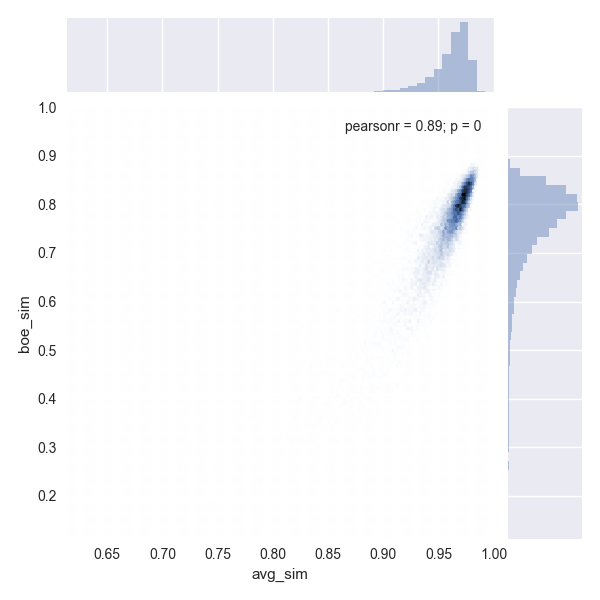

In [99]:
sb.jointplot('avg_sim', 'boe_sim', data=df_Q, kind='hex')

<IPython.core.display.Javascript object>


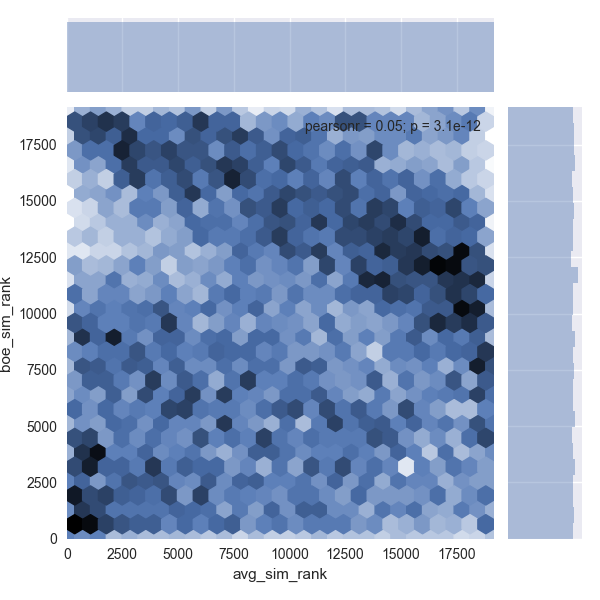

In [87]:
sb.jointplot('avg_sim_rank', 'boe_sim_rank', data=df_Q, kind='hex')